# Supervised Models: Linear and Logistic Regression

## Linear Regression

Despite its simplicity, a good understanding of linear regression is prerequisite for understanding how more advanced models work. Generally speaking, a linear model makes a prediction by simply computing a weighted
sum of the input features, plus a constant called the *bias* term (also called the *intercept*
term):

\begin{equation}
Y = a + b_1 X_1 + b_2 X_2 + \dots + b_m X_m + \epsilon
\end{equation}

where:

- $Y$ is the predicted value (the value of the target);
- $m$ is the number of features;
- $X_i$ is the $i^{th}$ feature value that are used to predict $Y$;
- $a$ and $b_j$ are the $j^{th}$ model parameters ($a$ being the bias term and $b_i$ the weights)
- $\epsilon$ is the predicton error.

As usual the parameters $a$ and $b_i$ are chosen to minimize the mean squared error over the training data set. 

This means that the task in linear regression is to find values for $a$ and $b_i$ that minimize

\begin{equation}
\frac{1}{n} \sum\limits_{i=1}^n \left( Y - a - b_1 X_{i1} - b_2 X_{i2} - \dots - b_m X_{im} \right)^2
\end{equation}

where $n$ is the size of the training set. 

Training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE), therefore, to train a Linear Regression model, you need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the Mean Square Error (MSE) than the RMSE, and it leads to the same result.


## Example 1 - Predicting Iowa House Prices (from Kaggle)

In [1]:
# loading packages 
import os
import pandas as pd
import numpy as np
# plotting packages
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

In [2]:
path = './data/'
data = pd.read_excel(path+"Original_Data_HousePrice.xlsx", header = 3)
data.shape

(2908, 83)

### This is an example of preprocessing

##### Remove column with high percentage of null values

In [3]:
null_column = (data.isnull().sum()/data.shape[0]).sort_values(ascending = False).head(30)
print(null_column)
column_to_drop = null_column[null_column >= 0.25].index
print("dropping columns: ", list(column_to_drop))
data.drop(columns = list(column_to_drop) + ['Id'], inplace = True)

Unnamed: 81     1.000000
Unnamed: 82     0.999656
PoolQC          0.997937
MiscFeature     0.963893
Alley           0.932256
Fence           0.804677
FireplaceQu     0.486933
LotFrontage     0.167125
GarageCond      0.054333
GarageQual      0.054333
GarageFinish    0.054333
GarageYrBlt     0.054333
GarageType      0.053989
BsmtExposure    0.027510
BsmtCond        0.027510
BsmtQual        0.027166
BsmtFinType2    0.026823
BsmtFinType1    0.026479
MasVnrType      0.008253
MasVnrArea      0.007909
MSZoning        0.001032
Utilities       0.000688
Electrical      0.000344
KitchenQual     0.000344
BsmtFullBath    0.000344
Exterior2nd     0.000344
BsmtHalfBath    0.000344
SaleType        0.000344
Exterior1st     0.000344
MoSold          0.000000
dtype: float64
dropping columns:  ['Unnamed: 81', 'Unnamed: 82', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


##### Remove rows with NaN values

In [4]:
print("dataframe shape:", data.shape)
data.dropna(inplace = True)
print("dataframe shape:", data.shape)

dataframe shape: (2908, 75)
dataframe shape: (2195, 75)


### Cleaning for categorical data
Here we drop categorical columns that show "always" the same value. We evaluate such property using Entropy.
Entropy is defined as: $E = -\sum_i p_i log p_i$. If a columns has only one class the entropy is 0, while if a column has equal frequency for each class the entropy is $E=log N$ where $N$ is the number of categories. Here we drop column with Entropy below to a given threshold.

In [5]:
from scipy.stats import entropy
cat_features = data.dtypes[data.dtypes == 'object'].index
cat_col_to_drop = []
for cat_col in cat_features:
    frequency = data[cat_col].value_counts()/data.shape[0]
    entropia = entropy(frequency.values)
    entropia = entropia/np.log(frequency.shape[0]) if entropia != 0 else 0 
    print(cat_col)
    print(frequency)
    print("entropia:", entropia)
    if (entropia < 0.4):
        cat_col_to_drop.append(cat_col)
print(cat_col_to_drop)
data.drop(columns=cat_col_to_drop, inplace=True)

MSZoning
RL         0.769021
RM         0.165831
FV         0.051025
RH         0.008200
C (all)    0.005923
Name: MSZoning, dtype: float64
entropia: 0.44830990249344743
Street
Pave    0.996811
Grvl    0.003189
Name: Street, dtype: float64
entropia: 0.031039315391049954
LotShape
Reg    0.695672
IR1    0.279271
IR2    0.020957
IR3    0.004100
Name: LotShape, dtype: float64
entropia: 0.5137549144453364
LandContour
Lvl    0.903872
HLS    0.046469
Bnk    0.036902
Low    0.012756
Name: LandContour, dtype: float64
entropia: 0.29673458197447633
Utilities
AllPub    1.0
Name: Utilities, dtype: float64
entropia: 0
LotConfig
Inside     0.763554
Corner     0.167654
CulDSac    0.038724
FR2        0.025968
FR3        0.004100
Name: LotConfig, dtype: float64
entropia: 0.46515556179676426
LandSlope
Gtl    0.954897
Mod    0.042369
Sev    0.002733
Name: LandSlope, dtype: float64
entropia: 0.17671934576846277
Neighborhood
NAmes      0.160364
CollgCr    0.097494
OldTown    0.088383
NridgHt    0.072437
Som

Here, for each categorical column, we label as "Other" each cat. with a frequency lower than 5%

In [6]:
cat_features = data.dtypes[data.dtypes == 'object'].index
for cat_col in cat_features:
    print(cat_col)
    frequency = (data[cat_col].value_counts()/data.shape[0])
    to_others = list(frequency[frequency<0.05].index)
    print(to_others)
    if len(to_others) > 1:
        data[cat_col] = data[cat_col].apply(lambda x: "Other" if x in to_others else x)

MSZoning
['RH', 'C (all)']
LotShape
['IR2', 'IR3']
LotConfig
['CulDSac', 'FR2', 'FR3']
Neighborhood
['Sawyer', 'SawyerW', 'NWAmes', 'BrkSide', 'Crawfor', 'Mitchel', 'IDOTRR', 'Timber', 'NoRidge', 'StoneBr', 'SWISU', 'BrDale', 'MeadowV', 'NPkVill', 'Blmngtn', 'ClearCr', 'Veenker', 'Blueste']
HouseStyle
['SLvl', 'SFoyer', '2.5Unf', '1.5Unf', '2.5Fin']
Exterior1st
['CemntBd', 'BrkFace', 'WdShing', 'AsbShng', 'Stucco', 'BrkComm', 'Stone', 'ImStucc', 'CBlock']
Exterior2nd
['CmentBd', 'Wd Shng', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc', 'AsphShn', 'Stone', 'Other', 'CBlock']
MasVnrType
['BrkCmn']
ExterQual
['Ex', 'Fa']
Foundation
['Stone', 'Wood']
BsmtQual
['Fa']
BsmtExposure
[]
BsmtFinType1
[]
HeatingQC
['Fa', 'Po']
KitchenQual
['Fa']
GarageType
['Basment', '2Types', 'CarPort']
GarageFinish
[]


Just a check everything worked

In [7]:
cat_features = data.dtypes[data.dtypes == 'object'].index
for cat_col in cat_features:
    frequency = (data[cat_col].value_counts()/data.shape[0])
    print(frequency)

RL       0.769021
RM       0.165831
FV       0.051025
Other    0.014123
Name: MSZoning, dtype: float64
Reg      0.695672
IR1      0.279271
Other    0.025057
Name: LotShape, dtype: float64
Inside    0.763554
Corner    0.167654
Other     0.068793
Name: LotConfig, dtype: float64
Other      0.404100
NAmes      0.160364
CollgCr    0.097494
OldTown    0.088383
NridgHt    0.072437
Somerst    0.068793
Edwards    0.058314
Gilbert    0.050114
Name: Neighborhood, dtype: float64
1Story    0.504328
2Story    0.302050
1.5Fin    0.112984
Other     0.080638
Name: HouseStyle, dtype: float64
VinylSd    0.374943
MetalSd    0.164920
HdBoard    0.140319
Wd Sdng    0.132574
Other      0.124374
Plywood    0.062870
Name: Exterior1st, dtype: float64
VinylSd    0.369932
MetalSd    0.164465
Other      0.134396
Wd Sdng    0.130296
HdBoard    0.126651
Plywood    0.074260
Name: Exterior2nd, dtype: float64
None       0.592711
BrkFace    0.297950
Stone      0.102506
BrkCmn     0.006834
Name: MasVnrType, dtype: float6

In [8]:
data.reset_index(drop=True, inplace=True)

In [13]:
data.to_csv(path+"Data_HousePrice_cleaned.csv", index=False)

In [14]:
cols = list(data.columns)
cols.remove('SalePrice')
X_feat = data[cols].copy()
Y_true = data['SalePrice'].copy()

In [15]:
cat_feat = X_feat.dtypes[X_feat.dtypes == 'object'].index
cat_dataset = X_feat[cat_feat].copy()
numerical_feat = X_feat.dtypes[X_feat.dtypes != 'object'].index
num_dataset = X_feat[numerical_feat].copy()

In [16]:
#num_dataset

Scaling numerical features !! 

In [17]:
#cat_feat, numerical_feat
from sklearn.preprocessing import StandardScaler
sd = StandardScaler()
sd.fit(num_dataset)
num_dataset_scaled = sd.transform(num_dataset)
df = pd.DataFrame(num_dataset_scaled, columns=numerical_feat)
df.shape

(2195, 36)

get dummies for categorical features

In [18]:
cat_dummies = pd.get_dummies(cat_dataset)
cat_dummies.shape

(2195, 74)

In [19]:
#cat_dummies

In [20]:
X_df = pd.concat([df, cat_dummies], axis = 1)

In [21]:
X_df.shape

(2195, 110)

#### Linear Regression with sklearn

In [22]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [23]:
Y = Y_true.values

In [24]:
sd = StandardScaler()
sd.fit(Y.reshape(-1,1))
Y_scaled = sd.transform(Y.reshape(-1,1))

In [25]:
lr = LinearRegression()
lr.fit(X_df.values,Y_scaled)

LinearRegression()

In [26]:
y_pred = lr.predict(X_df.values)

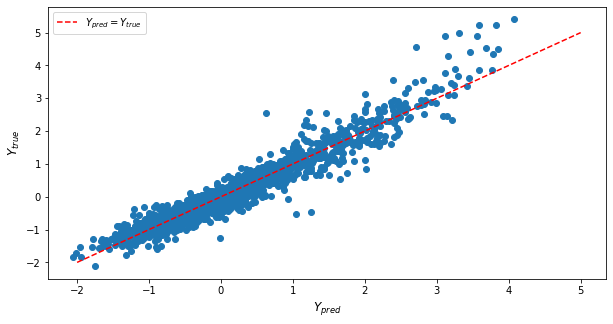

mean_absolute_error: 0.18981827612619157
mean_squared_error: 0.07377980852911352
mean_absolute_percentage_error: 4.04808381403323


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

fig , ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(y_pred, Y_scaled)
ax.plot([-2,5],[-2,5], "--", c='red', label = "$Y_{pred} = Y_{true}$")
ax.set_xlabel("$Y_{pred}$", fontsize = 12)
ax.set_ylabel("$Y_{true}$", fontsize = 12)
plt.legend()
plt.show()
print("mean_absolute_error:", mean_absolute_error(y_pred, Y_scaled))
print("mean_squared_error:", mean_squared_error(y_pred, Y_scaled))
print("mean_absolute_percentage_error:", mean_absolute_percentage_error(y_pred, Y_scaled))

In [28]:
coeffs = pd.DataFrame( [list(lr.intercept_) + list(lr.coef_[0])],  columns= ['intercept'] + list(X_df.columns))
coeffs

,intercept,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_Other,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_Other,LotShape_Reg,LotConfig_Corner,LotConfig_Inside,LotConfig_Other,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Somerst,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_Other,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,3.057918e+11,-0.057986,0.008795,0.060989,0.165029,0.08259,0.10314,0.019098,0.095377,-1.300236e+11,-4.921807e+10,-1.295792e+11,1.152385e+11,-3.851425e+10,-4.335586e+10,-4.508298e+09,4.908238e+10,-0.001674,-0.014302,0.011626,0.016103,-0.049637,-0.049442,0.02065,0.013634,0.002077,0.020267,0.052703,0.011308,0.001598,0.000399,0.002288,0.031696,-0.00738,0.005323,0.000317,-0.013634,-9.905662e+09,-9.905662e+09,-9.905662e+09,-9.905662e+09,-3.867452e+10,-3.867452e+10,-3.867452e+10,2.015664e+10,2.015664e+10,2.015664e+10,2.257600e+10,2.257600e+10,2.257600e+10,2.257600e+10,2.257600e+10,2.257600e+10,2.257600e+10,2.257600e+10,-5.112299e+10,-5.112299e+10,-5.112299e+10,-5.112299e+10,-8.387814e+09,-8.387814e+09,-8.387814e+09,-8.387814e+09,-8.387814e+09,-8.387814e+09,3.422454e+09,3.422454e+09,3.422454e+09,3.422454e+09,3.422454e+09,3.422454e+09,-4.070045e+10,-4.070045e+10,-4.070045e+10,-4.070045e+10,-5.046109e+10,-5.046109e+10,-5.046109e+10,4.031677e+09,4.031677e+09,4.031677e+09,4.031677e+09,2.213199e+10,2.213199e+10,2.213199e+10,2.213199e+10,-2.553532e+10,-2.553532e+10,-2.553532e+10,-2.553532e+10,-1.753778e+09,-1.753778e+09,-1.753778e+09,-1.753778e+09,-1.753778e+09,-1.753778e+09,3.181328e+09,3.181328e+09,3.181328e+09,3.181328e+09,-5.321863e+10,-5.321863e+10,-5.321863e+10,-5.321863e+10,-1.152285e+10,-1.152285e+10,-1.152285e+10,-1.152285e+10,-9.000875e+10,-9.000875e+10,-9.000875e+10


a lot of coefficients are very high, this is a signature of overfitting (that we will study in chapter 5). To prevent overfitting we will use regolarization methods.

###### Ridge Regression

In [29]:
# Importing Ridge
from sklearn.linear_model import Ridge

We try using Ridge regression with different values of the hyperparameter $\lambda$. The following code shows the effect of this parameter on the prediction error. 

In [30]:
def plot_result(y_prediction, Y_true):
    fig , ax = plt.subplots(1,1,figsize=(10,5))
    ax.scatter(y_prediction, Y_true)
    ax.plot([-2,5],[-2,5], "--", c='red', label = "$Y_{pred} = Y_{true}$")
    ax.set_xlabel("$Y_{pred}$", fontsize = 12)
    ax.set_ylabel("$Y_{true}$", fontsize = 12)
    plt.legend()
    plt.show()
    print("mean_absolute_error:", mean_absolute_error(y_prediction, Y_true))
    print("mean_squared_error:", mean_squared_error(y_prediction, Y_true))
    print("mean_absolute_percentage_error:", mean_absolute_percentage_error(y_prediction, Y_true))

ALPHA: 0.1


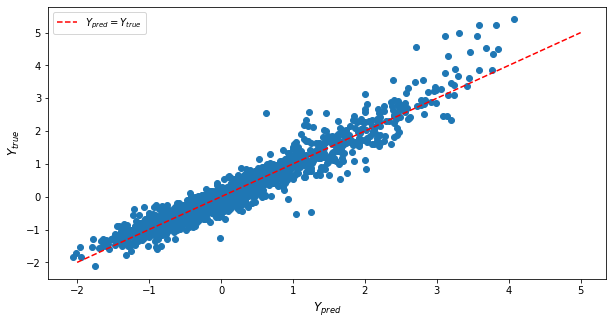

mean_absolute_error: 0.1898261558015354
mean_squared_error: 0.07377959729619883
mean_absolute_percentage_error: 1.9184657780784404
ALPHA: 1


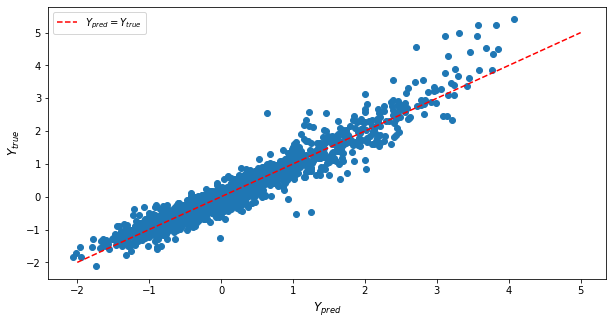

mean_absolute_error: 0.1897863889838735
mean_squared_error: 0.0737818939971761
mean_absolute_percentage_error: 1.999069004185878
ALPHA: 5


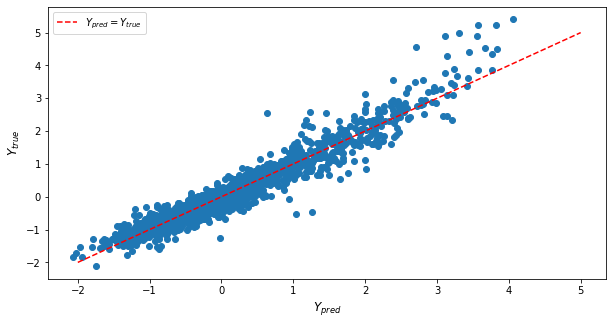

mean_absolute_error: 0.1897544759391014
mean_squared_error: 0.0738227606291307
mean_absolute_percentage_error: 3.0200615861730946
ALPHA: 10


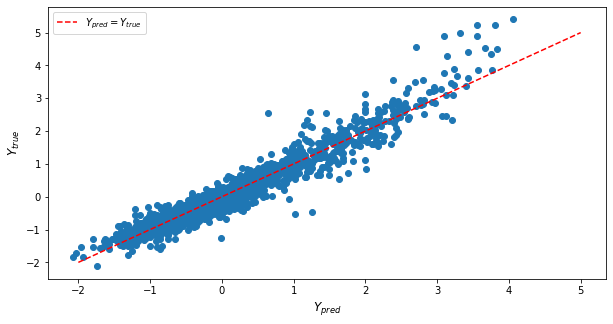

mean_absolute_error: 0.1898085589890219
mean_squared_error: 0.07391179137424933
mean_absolute_percentage_error: 1.8278334642430156
ALPHA: 20


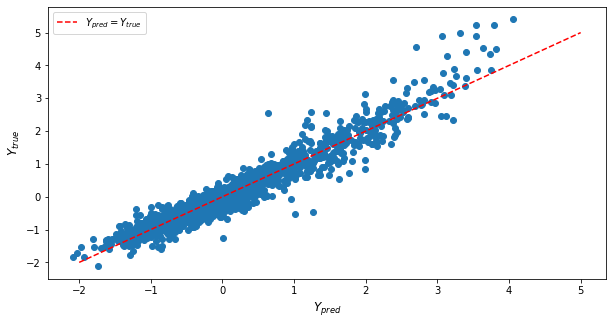

mean_absolute_error: 0.19004162941430003
mean_squared_error: 0.07414579952519257
mean_absolute_percentage_error: 2.6060214433522466
ALPHA: 100


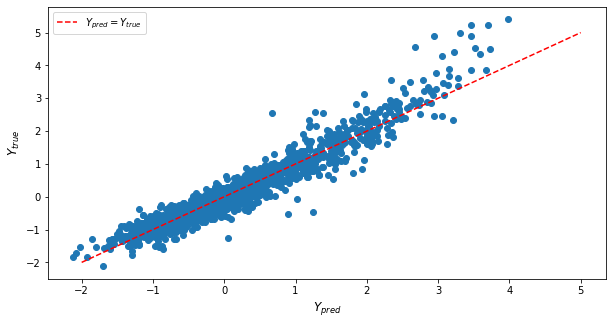

mean_absolute_error: 0.19257906655340645
mean_squared_error: 0.0766388750821531
mean_absolute_percentage_error: 1.0020224098497328
ALPHA: 200


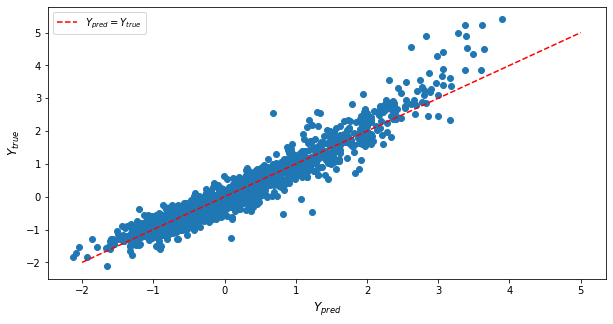

mean_absolute_error: 0.19595474124678006
mean_squared_error: 0.07997168764811063
mean_absolute_percentage_error: 1.8605502752381957
ALPHA: 500


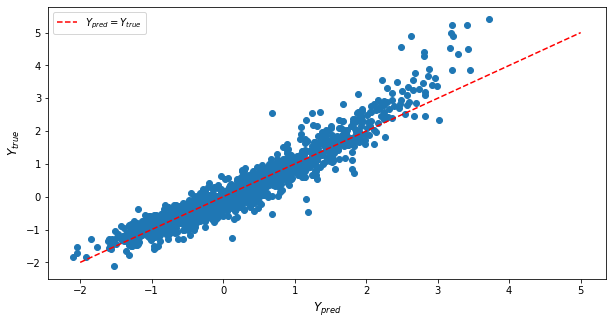

mean_absolute_error: 0.20502038098266634
mean_squared_error: 0.08927173627970822
mean_absolute_percentage_error: 0.9138748686284202
ALPHA: 1000


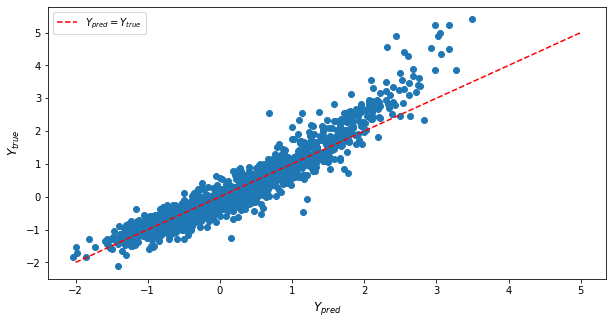

mean_absolute_error: 0.21631402755796714
mean_squared_error: 0.10253163521543625
mean_absolute_percentage_error: 1.8871660089225235


In [31]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
alphas=[0.1, 1, 5, 10, 20, 100, 200, 500, 1000]
mses=[]
dfs_coeff = []
colonne = ['intercept'] + list(X_df.columns)
for alpha in alphas:
    print("ALPHA:", alpha)
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_df.values,Y_scaled)
    pred=ridge.predict(X_df.values)
    mses.append(mean_squared_error(Y_scaled,pred))
    plot_result(pred, Y_scaled)
    
    coeffs = list(ridge.intercept_) + list(ridge.coef_[0])
    alpha_value  = [alpha for i in range(len(coeffs))]
    pippo = []
    for a,b,c in zip(alpha_value,colonne,coeffs):
        #print(a,b,c)
        pippo.append([a,b,c])
    df_result_coeff = pd.DataFrame(pippo, columns=["alpha", "features", "coeff"])
    #df_result_coeff = pd.DataFrame([[alpha for i in range(len(coeffs))],colonne, coeffs], columns=["alpha", "features", "coeff"])
    dfs_coeff.append(df_result_coeff)

In [32]:
#mses

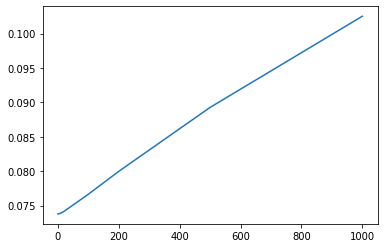

In [33]:
plt.plot(alphas, mses)

As expected the prediction error increases as $\lambda$ increases. Values of $\lambda$ in the range $0$ to $0.1$ might be reasonably be considered because prediction errors increases only slightly when $\lambda$ is in this range. However it turns out that the improvement in the model is quite small for these values of $\lambda$.

In [34]:
dfs_coeff.append(df_result_coeff)

### Lasso

In [35]:
# Import Lasso
from sklearn.linear_model import Lasso

In [36]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.04)
lasso.fit(X_df.values,Y_scaled)

Lasso(alpha=0.04)

In [37]:
coeffs = pd.DataFrame( [list(lasso.intercept_) + list(lasso.coef_)],  columns= ['intercept'] + list(X_df.columns))
coeffs

,intercept,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_Other,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_Other,LotShape_Reg,LotConfig_Corner,LotConfig_Inside,LotConfig_Other,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Somerst,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_Other,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,-0.002168,-0.012132,0.0,0.056234,0.319659,0.0,0.032119,0.078558,0.06444,0.121421,0.0,-0.0,0.141554,0.0,0.0,-0.0,0.301584,0.0,-0.0,0.0,0.0,-0.0,-0.03859,0.0,0.011098,0.0,0.008515,0.086119,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.021342,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0


###### Lasso with different levels of alpha and its mse

alpha : 0.005


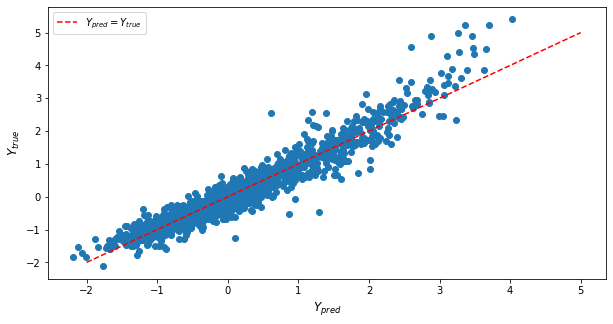

mean_absolute_error: 0.1978737616836553
mean_squared_error: 0.08072352073058725
mean_absolute_percentage_error: 1.3878484517684697
alpha : 0.01


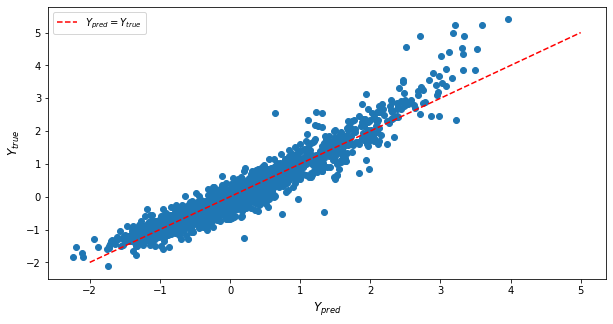

mean_absolute_error: 0.20470100785604903
mean_squared_error: 0.08705577139897379
mean_absolute_percentage_error: 1.8935402363587386
alpha : 0.015


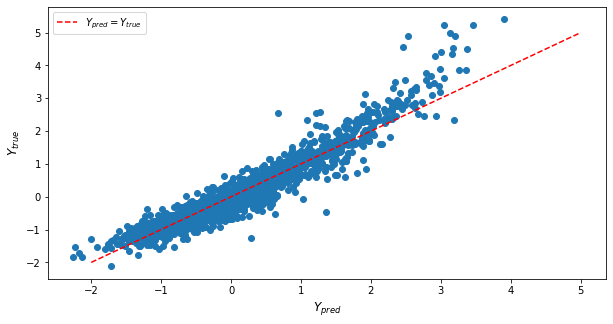

mean_absolute_error: 0.2133060743615349
mean_squared_error: 0.0943090288313235
mean_absolute_percentage_error: 1.3113043696067168
alpha : 0.02


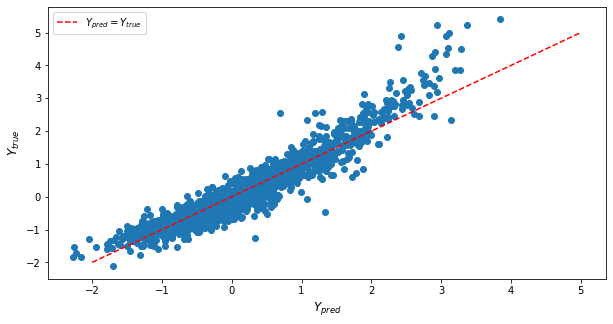

mean_absolute_error: 0.22072285803466002
mean_squared_error: 0.10079168123215454
mean_absolute_percentage_error: 1.5084194309099057
alpha : 0.025


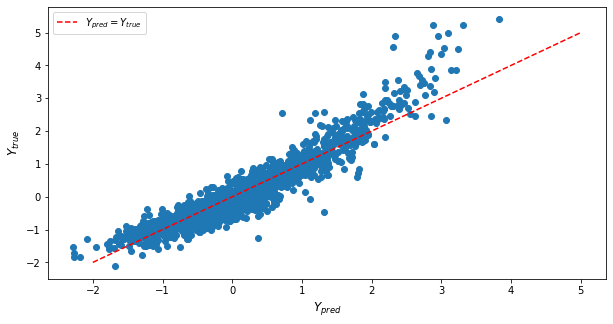

mean_absolute_error: 0.22750275062143854
mean_squared_error: 0.1068120345250848
mean_absolute_percentage_error: 1.1344219750179185
alpha : 0.03


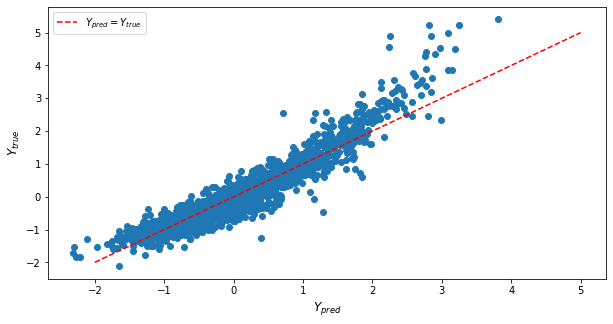

mean_absolute_error: 0.2356904902238897
mean_squared_error: 0.11413882678098977
mean_absolute_percentage_error: 1.6367022775245212
alpha : 0.04


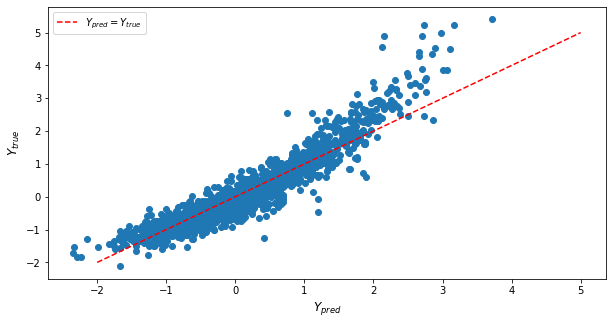

mean_absolute_error: 0.24693643160991877
mean_squared_error: 0.12530350487815237
mean_absolute_percentage_error: 2.4920718655552143
alpha : 0.045


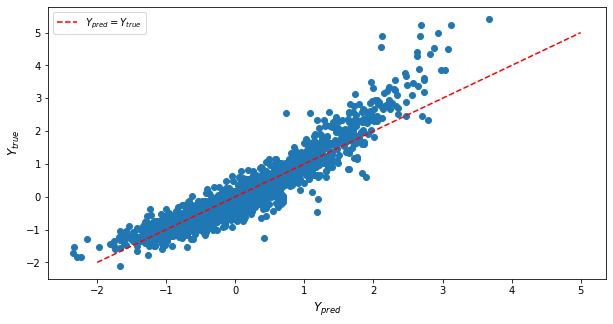

mean_absolute_error: 0.24965333286532962
mean_squared_error: 0.12847041846226112
mean_absolute_percentage_error: 1.2066387002487828
alpha : 0.05


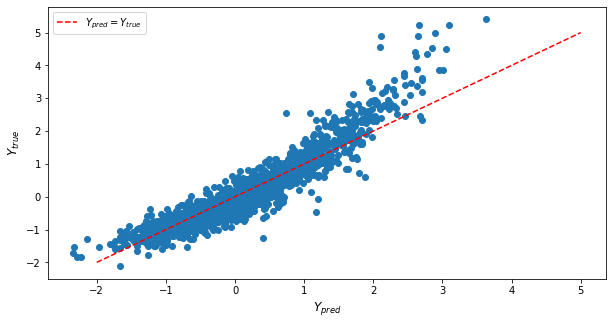

mean_absolute_error: 0.25122101814300335
mean_squared_error: 0.13053227972761014
mean_absolute_percentage_error: 2.1140099170904256


In [38]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.06/2, 0.08/2, 0.09/2, 0.1/2]
mses=[]
for alpha in alphas:
    print("alpha :", alpha)
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_df.values,Y_scaled)
    pred=lasso.predict(X_df.values)
    mses.append(mse(Y_scaled,pred))
    plot_result(pred, Y_scaled)

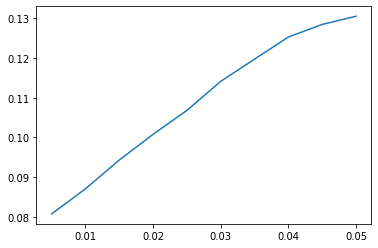

In [39]:
plt.plot(alphas, mses)

In [40]:
coeffs = pd.DataFrame( [list(lasso.intercept_) + list(lasso.coef_)],  columns= ['intercept'] + list(X_df.columns))
coeffs

,intercept,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_Other,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_Other,LotShape_Reg,LotConfig_Corner,LotConfig_Inside,LotConfig_Other,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Somerst,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_Other,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,6.912194e-17,-0.003924,0.0,0.051578,0.325476,0.0,0.027877,0.073852,0.060438,0.116623,0.0,-0.0,0.146021,0.0,0.0,-0.0,0.295759,0.0,-0.0,0.0,0.0,-0.0,-0.031376,0.0,0.007498,0.0,0.006686,0.086661,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0


### Kernel Ridge Regression

In [41]:
from sklearn.kernel_ridge import KernelRidge

alpha : 0.005


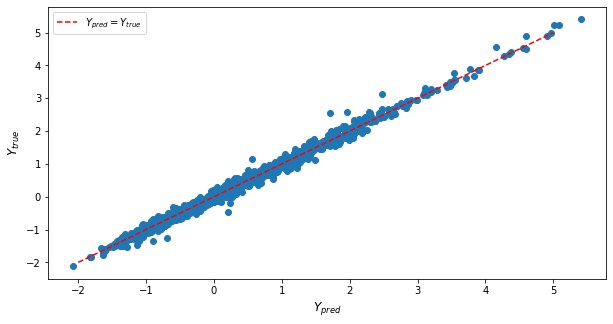

mean_absolute_error: 0.06384767034296526
mean_squared_error: 0.008536257034507203
mean_absolute_percentage_error: 0.42680822892866166
alpha : 0.01


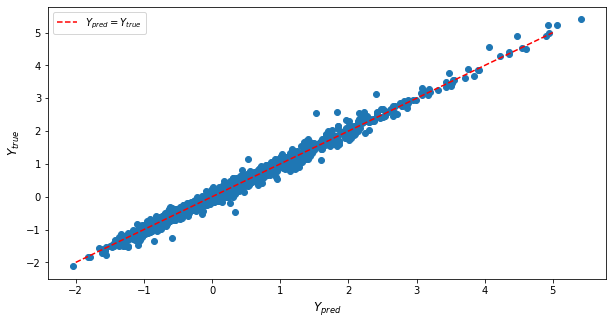

mean_absolute_error: 0.07531706126092091
mean_squared_error: 0.011688407787182683
mean_absolute_percentage_error: 0.4747032766437046
alpha : 0.015


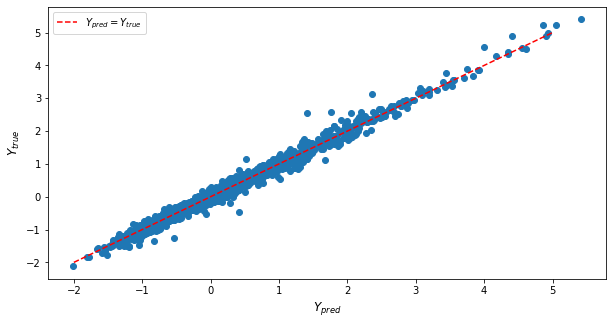

mean_absolute_error: 0.08212358240845598
mean_squared_error: 0.013835317425586937
mean_absolute_percentage_error: 0.6538722763885186
alpha : 0.02


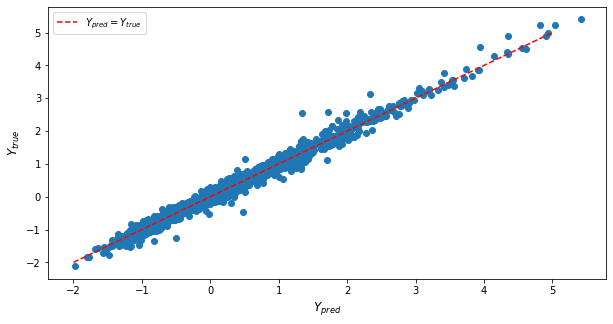

mean_absolute_error: 0.086970329936367
mean_squared_error: 0.015492667852014117
mean_absolute_percentage_error: 0.9351387232849934
alpha : 0.025


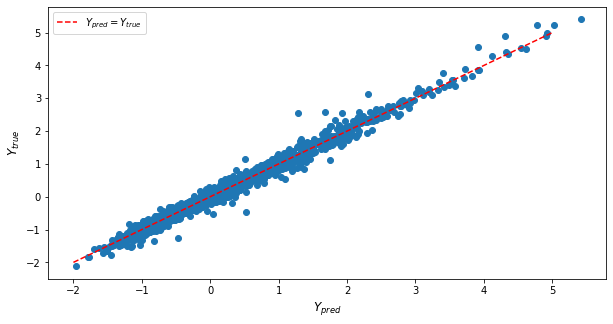

mean_absolute_error: 0.09069764167544328
mean_squared_error: 0.016851148313525424
mean_absolute_percentage_error: 0.6063336893394985
alpha : 0.03


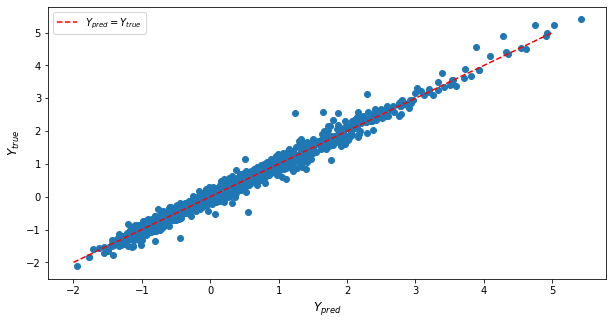

mean_absolute_error: 0.09371368686934307
mean_squared_error: 0.018005366586733643
mean_absolute_percentage_error: 0.7130543804243629
alpha : 0.04


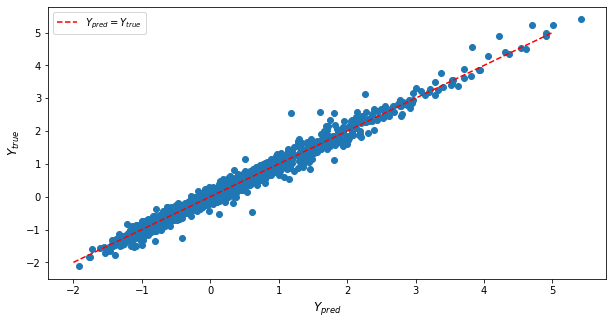

mean_absolute_error: 0.09843020360008935
mean_squared_error: 0.01990003773847696
mean_absolute_percentage_error: 0.8444348132645355
alpha : 0.045


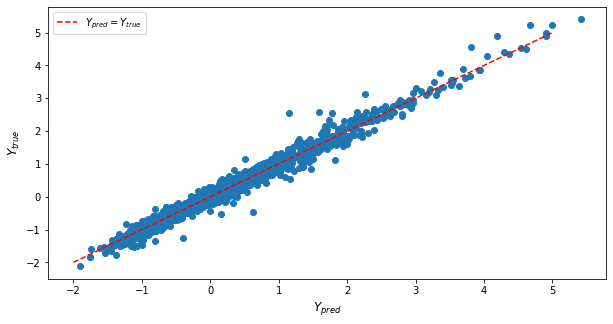

mean_absolute_error: 0.10034997544178059
mean_squared_error: 0.020699044310966377
mean_absolute_percentage_error: 0.7100774994117228
alpha : 0.05


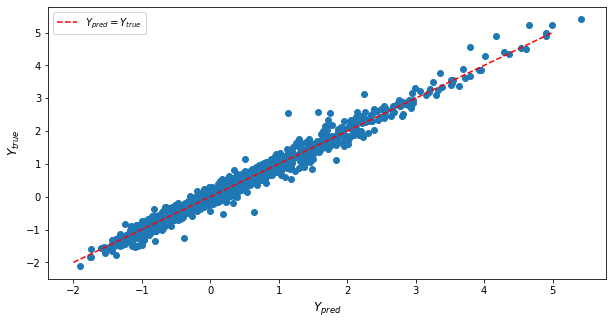

mean_absolute_error: 0.10205929580986207
mean_squared_error: 0.02142399742313119
mean_absolute_percentage_error: 1.3446493963966464


In [44]:
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.06/2, 0.08/2, 0.09/2, 0.1/2]
mses=[]
for alpha in alphas:
    print("alpha :", alpha)
    kernel_ridge=KernelRidge(alpha=alpha, kernel = "polynomial", degree=2)
    kernel_ridge.fit(X_df.values,Y_scaled)
    pred=kernel_ridge.predict(X_df.values)
    mses.append(mse(Y_scaled,pred))
    plot_result(pred, Y_scaled)